In [1]:
import random
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Input

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

### build the vocab of chars and lookup tables

In [21]:
# build the vocab of chars and lookup tables
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [22]:
# shuffle the words
random.seed(42)
random.shuffle(words)

In [32]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], [] # inp and op
    for word in words:
        # context initialization: for the first letter it will just be '.' 8 times because the context size is 8 rn!
        context = [0] * block_size 
        # create input i.e context from each word
        for char in word + '.':
            X.append(context)
            y_ix = stoi_lookup[char]
            Y.append(y_ix)
            context = context[1:] + [y_ix]

    X = torch.tensor(X) # or torch.tensor
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y

tr_win_end = int(0.8 * len(words))
test_win_end = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:tr_win_end])  # use to optimise the model params
X_val, Y_val = build_dataset(words[tr_win_end: test_win_end]) # use for hyperparameters tuning(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[test_win_end:]) # use for evaluating the performance of the model

shapes:  torch.Size([182580, 3]) torch.Size([182580])
shapes:  torch.Size([22767, 3]) torch.Size([22767])
shapes:  torch.Size([22799, 3]) torch.Size([22799])


In [33]:
for x, y in zip(X_tr[:15], Y_tr[:15]):
    print("".join(itos_lookups[i.item()] for i in x), '----->', itos_lookups[y.item()])

... -----> e
..e -----> b
.eb -----> r
ebr -----> i
bri -----> m
rim -----> a
ima -----> .
... -----> h
..h -----> i
.hi -----> l
hil -----> t
ilt -----> o
lto -----> n
ton -----> .
... -----> j



![Batch Normalization](batch_norm.png)

In [54]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # fan_in ** 0.5 is kaiming init for good initalization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # w * x + b
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def params(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum # for updating the running buffers(mean and var)
        self.training = True # track buffers or not

        # batch norm params - scale and shift
        self.gamma = torch.ones(dim) # scale by default 1 
        self.beta = torch.zeros(dim) # shift by default 0

        # track running mean and var with buffers
        self.running_mean = torch.zeros(dim) # for Gaussian it should be 0
        self.running_var = torch.ones(dim) # for Gaussian it should be 1

    def __call__(self, x):
        # forward pass
        
        # ------------ normalize the mini batch with mean and var ------------
        if self.training:
            if x.ndim ==2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            # calculate mean and var for every mini batch while training
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        # if we are not training then the mean and variance will be inferred from the running buffers
        else:
            # used for normalization during evaluation(validation and testing)
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) /torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta # scale and shift
        #-----------------------------------------------------------------------

        # ----------------track buffers-------------
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        # ------------------------------------------
        
        return self.out
    
    def params(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def params(self):
        return []

modularizing the embeddings and concatenation/flattening of the vectors

In [58]:
# embeddings - previously emb = C[X]
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def params(self):
        return [self.weight]

# concatenation/flattening - previously emb_cat = emb.view(emb.shape[0], -1)
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def params(self):
        return []

containerizing(akin to PyTorch's container) the layers

In [64]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        # call the layers Sequentially
        for layer in self.layers:
            x = layer(x)
        self.out = x
        # return the output of the layers at the end
        return self.out
    
    def params(self):
        # params of all the layers
        return [p for layer in self.layers for p in layer.params()]

In [37]:
torch.manual_seed(42)

In [88]:
dim_embd = 10   # dimensionality of the character embedding vectors i.e vector size
n_hidden = 200  # number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, dim_embd)) # embedding vectors for the entire vocab

# layers = [
#     Embedding(vocab_size, dim_embd),
#     Flatten(),
#     Linear(dim_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size),
# ]

model = Sequential([
    Embedding(vocab_size, dim_embd),
    Flatten(),
    Linear(dim_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), Linear(n_hidden, vocab_size),
])

# initialization
with torch.no_grad():
    # for the output layer scale down the weights so we arent confidently wrong at init
    model.layers[-1].weight *= 0.1

params = model.params()

print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

12097


In [89]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    # minintach construction
    ix = torch.randint(0, X_tr.shape[0], (batch_size, ))
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # forward pass
    # old way without container
    # for layer in layers:
    #     x = layer(x)
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    # set the gradients to 0 for each backward pass, dont accumulate them from the prev bacth
    for p in params:
        p.grad = None
    loss.backward()
    
    l_rate = 0.1 if step < 150000 else 0.01 # learning rate with decay
    
    # update params according to the grad and learning rate
    for p in params:
        p.data += -l_rate * p.grad

    # track stats
    if step % 10000 == 0: # print periodically
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())
    
    # if step >= 1000:
    #     break

# print(f'{loss=}')

      0/ 200000:3.2938
  10000/ 200000:1.9267
  20000/ 200000:2.4295
  30000/ 200000:1.9769
  40000/ 200000:2.3251
  50000/ 200000:2.4141
  60000/ 200000:1.9281
  70000/ 200000:2.5050
  80000/ 200000:2.4075
  90000/ 200000:2.1683
 100000/ 200000:2.0072
 110000/ 200000:1.9271
 120000/ 200000:2.3686
 130000/ 200000:2.2904
 140000/ 200000:2.1627
 150000/ 200000:1.8151
 160000/ 200000:2.0722
 170000/ 200000:2.2141
 180000/ 200000:2.0203
 190000/ 200000:2.4212


average loss distribution for every 1000 steps

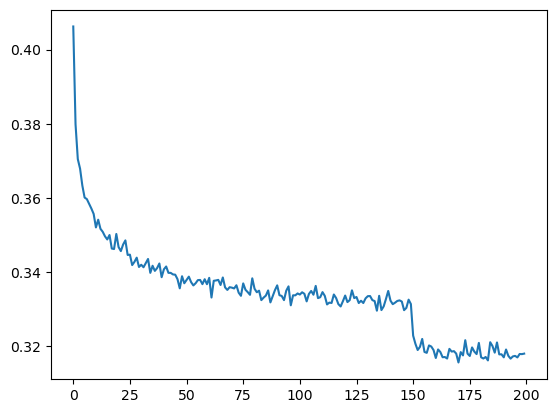

In [90]:
plt.plot(torch.tensor(losses_at_idx).view(-1, 1000).mean(1));

Evaluate the model

In [91]:
for layer in model.layers:
    layer.training = False

In [92]:
@torch.no_grad()
def split_loss(split_name):
    # forward pass
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split_name]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    print(split_name, loss.item())

split_loss('train')
split_loss('val')

train 2.0600337982177734
val 2.105538845062256


the train and val losses are similar, so the model is not overfitting

sampling from the model

In [105]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # make sure that the layer.training is set False or else we will be giving a single input to a batch norm, 
        # var of single number is nan, mean will be ok though
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1) # calculate probs from logits with softmax
        ix = torch.multinomial(probs, num_samples = 1).item()
        out.append(ix)
        context = context[1:] + [ix] # update the context
        if ix == 0: # EOS
            break

    print("".join(itos_lookups[i] for i in out))

grady.
elie.
han.
desta.
chett.
hutte.
katoria.
gian.
joana.
ayleigh.
asifse.
jon.
ber.
erriel.
per.
cky.
madiah.
angelen.
mery.
bresyn.


 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__